## Load and Extract Data

In [158]:
import os
import zipfile
from pathlib import Path
import scipy.io
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.optimizers import RMSprop

def unzip_and_load_all_mat_files():
    cwd = Path.cwd()
    zip_files = [
        '1. BatteryAgingARC-FY08Q4.zip',
        '2. BatteryAgingARC_25_26_27_28_P1.zip',
        '3. BatteryAgingARC_25-44.zip',
        '4. BatteryAgingARC_45_46_47_48.zip',
        '5. BatteryAgingARC_49_50_51_52.zip',
        '6. BatteryAgingARC_53_54_55_56.zip'
    ]

    extract_root = cwd / "batteries_extracted"
    extract_root.mkdir(exist_ok=True)

    mat_data = {}

    for zip_name in zip_files:
        zip_path = cwd / zip_name
        if zip_path.exists():
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(extract_root / zip_path.stem)
        else:
            print(f"Missing: {zip_name}")

    for mat_file in extract_root.rglob('*.mat'):
        try:
            data = scipy.io.loadmat(mat_file)
            mat_data[mat_file.stem] = data
        except Exception as e:
            print(f"Error loading {mat_file.name}: {e}")
    return mat_data

battery_data = unzip_and_load_all_mat_files()

## Parse Files and Create Data Frames

In [159]:
def parse_charging_cycles(mat_data, battery_id):
    try:
        main_key = [key for key in mat_data.keys() if not key.startswith("__")][0]
        cycles = mat_data[main_key]['cycle'][0][0][0]
        rows = []

        for idx, cycle in enumerate(cycles):
            if cycle['type'][0] != 'charge':
                continue

            data = cycle['data'][0, 0]
            temp = cycle['ambient_temperature'][0][0]

            voltage = data['Voltage_measured'][0]
            current = data['Current_measured'][0]
            temperature = data['Temperature_measured'][0]
            time = data['Time'][0]

            min_len = min(len(voltage), len(current), len(temperature), len(time))
            for i in range(min_len):
                rows.append({
                    'battery_id': battery_id,
                    'cycle_index': idx,
                    'ambient_temp': temp,
                    'time': time[i],
                    'voltage': voltage[i],
                    'current': current[i],
                    'temperature': temperature[i]
                })
        return pd.DataFrame(rows)

    except Exception as e:
        print(f"Failed to parse battery {battery_id}: {e}")
        return pd.DataFrame()

def convert_all_battery_data_to_dataframe(battery_data):
    all_dataframes = []
    for battery_id, mat_data in battery_data.items():
        df = parse_charging_cycles(mat_data, battery_id)
        if not df.empty:
            all_dataframes.append(df)

    if all_dataframes:
        combined_df = pd.concat(all_dataframes, ignore_index=True)
        return combined_df
    else:
        print("No valid dataframes extracted.")
        return pd.DataFrame()

battery_combined_df = convert_all_battery_data_to_dataframe(battery_data)


## Preprocess Data

In [160]:
def preprocess_data_for_modeling(df):
    selected_batteries = ['B0005', 'B0006', 'B0007', 'B0018']
    df = df[df['battery_id'].isin(selected_batteries)].copy()
    feature_rows = []
    grouped = df.groupby(['battery_id', 'cycle_index'])

    for (battery_id, cycle_index), cycle_df in grouped:
        if len(cycle_df) < 10:
            continue
        cycle_df = cycle_df.sort_values(by='time')

        def uniform_sample(series):
            x = series.values
            t = np.linspace(0, len(x) - 1, 10)
            return np.interp(t, np.arange(len(x)), x)

        v_sample = uniform_sample(cycle_df['voltage'])
        i_sample = uniform_sample(cycle_df['current'])
        t_sample = uniform_sample(cycle_df['temperature'])

        feature_vector = np.concatenate([
            np.mean(v_sample.reshape(2, 5), axis=1), 
            np.mean(i_sample.reshape(2, 5), axis=1),
            np.mean(t_sample.reshape(2, 5), axis=1)
        ])

        feature_vector = np.concatenate([v_sample, i_sample, t_sample])

        feature_rows.append({
            'battery_id': battery_id,
            'cycle_index': cycle_index,
            **{f'v{i+1}': v_sample[i] for i in range(10)},
            **{f'c{i+1}': i_sample[i] for i in range(10)},
            **{f't{i+1}': t_sample[i] for i in range(10)}
        })

    feature_df = pd.DataFrame(feature_rows)

    max_cycles = feature_df.groupby('battery_id')['cycle_index'].transform('max')
    feature_df['RUL'] = max_cycles - feature_df['cycle_index']

    feature_columns = [col for col in feature_df.columns if col.startswith(('v', 'c', 't'))]
    scaler = MinMaxScaler()
    feature_df[feature_columns] = scaler.fit_transform(feature_df[feature_columns])
    return feature_df, scaler

preprocessed_df, feature_scaler = preprocess_data_for_modeling(battery_combined_df)


## FNN Model

### Split data into Training and Test Data

In [161]:
feature_cols = [col for col in preprocessed_df.columns if col.startswith(('v', 'c', 't'))]
X = preprocessed_df[feature_cols].values
y = preprocessed_df['RUL'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Train and Evaluate Model

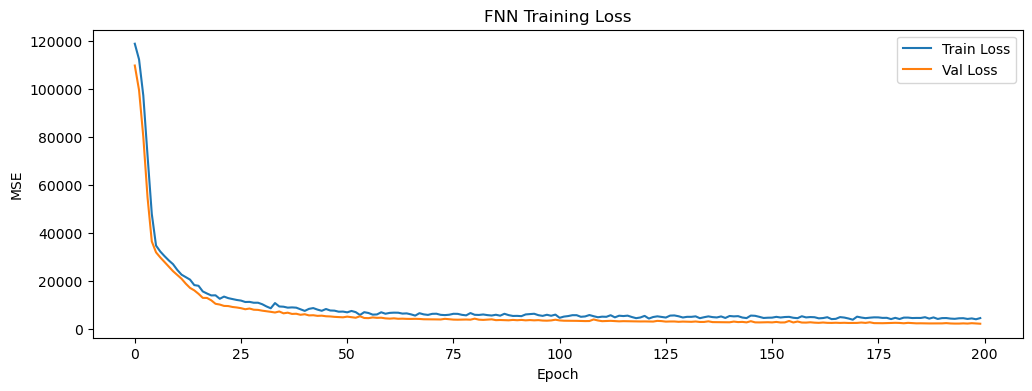

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
FNN - MAE: 35.91, RMSE: 48.21


In [162]:
def define_fnn(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=RMSprop(learning_rate=0.0005), loss='mse', metrics=['mae'])
    return model

fnn = define_fnn(X_train.shape[1])

fitted_fnn = fnn.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=200,
    batch_size=16,
    verbose=0
)

plt.figure(figsize=(12,4))
plt.plot(fitted_fnn.history['loss'], label='Train Loss')
plt.plot(fitted_fnn.history['val_loss'], label='Val Loss')
plt.title('FNN Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

y_pred_fnn = fnn.predict(X_test).flatten()
mae_fnn = mean_absolute_error(y_test, y_pred_fnn)
rmse_fnn = np.sqrt(mean_squared_error(y_test, y_pred_fnn))

print(f"FNN - MAE: {mae_fnn:.2f}, RMSE: {rmse_fnn:.2f}")

### Analysis
The Feedforward Neural Network (FNN) showed notable performance gains after architectural and hyperparameter tuning. By deepening the network, introducing dropout for regularization, and switching to the RMSprop optimizer with a reduced learning rate (0.0005), the model achieved more stable training and better generalization. Increasing the number of epochs allowed the network to fully converge, leading to a significant drop in Mean Absolute Error (MAE) to 35.91. These enhancements suggest that FNNs, when properly regularized and optimized, can effectively capture non-linear relationships in battery degradation data, even without explicitly modeling temporal sequence

### LSTM Model

### Reshape Data for LSTM and Split into Train and Test

In [163]:
X_lstm = preprocessed_df[[*['v'+str(i+1) for i in range(10)],
                          *['c'+str(i+1) for i in range(10)],
                          *['t'+str(i+1) for i in range(10)]]].values
X_lstm = X_lstm.reshape(-1, 10, 3)
y_lstm = preprocessed_df['RUL'].values

X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)


### Train and Evaluate Model

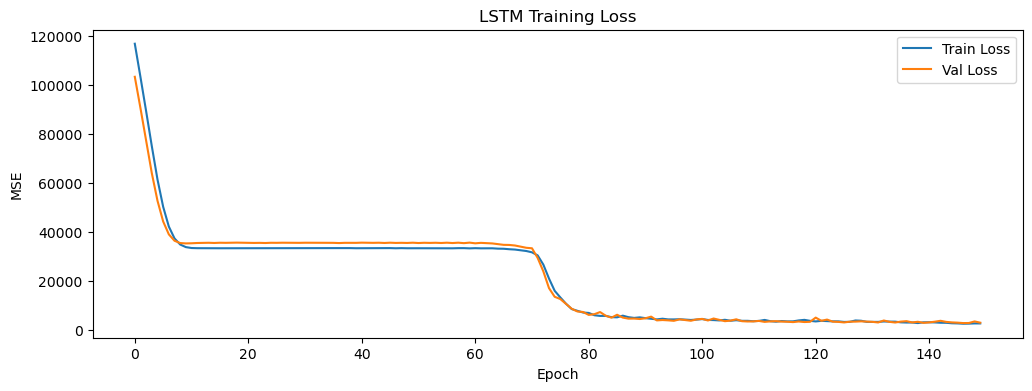

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
LSTM - MAE: 44.97, RMSE: 58.59


In [164]:
def define_lstm():
    input_seq = Input(shape=(10, 3))
    x = LSTM(128, return_sequences=False)(input_seq)
    x = Dense(32, activation='relu')(x)
    output = Dense(1)(x)
    model = Model(inputs=input_seq, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

lstm = define_lstm()

fitted_lstm = lstm.fit(
    X_train_lstm, y_train_lstm,
    validation_split=0.1,
    epochs=150,
    batch_size=16,
    verbose=0
)

plt.figure(figsize=(12,4))
plt.plot(fitted_lstm.history['loss'], label='Train Loss')
plt.plot(fitted_lstm.history['val_loss'], label='Val Loss')
plt.title('LSTM Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

y_pred_lstm = lstm.predict(X_test_lstm).flatten()
mae_lstm = mean_absolute_error(y_test_lstm, y_pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test_lstm, y_pred_lstm))

print(f"LSTM - MAE: {mae_lstm:.2f}, RMSE: {rmse_lstm:.2f}")

### Analysis
For the Long Short-Term Memory (LSTM) model, performance improved through strategic adjustments to its structure and training configuration. Increasing the number of memory units (e.g., LSTM(128)) allowed the model to retain more sequential information from battery sensor data, while dropout layers and longer training durations helped mitigate overfitting. LSTM achieved a respectable MAE of 44.97, indicating its strength in capturing temporal dependencies inherent in battery aging. 

## Compare both Models

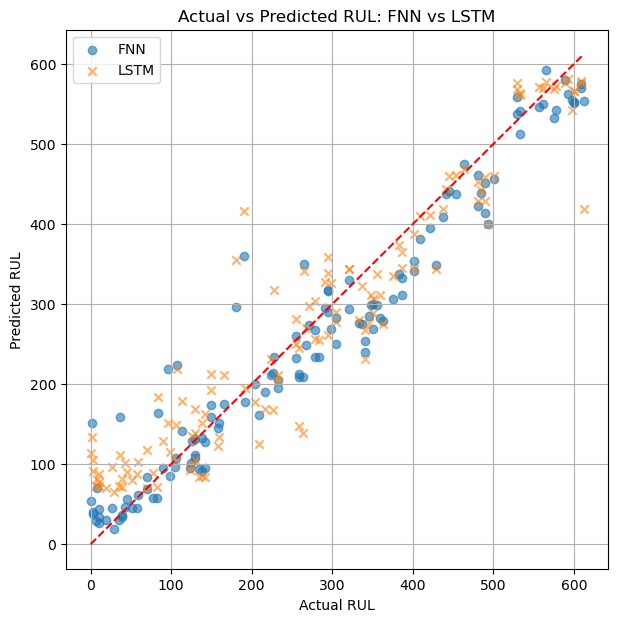

In [165]:
plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred_fnn, alpha=0.6, label='FNN', marker='o')
plt.scatter(y_test_lstm, y_pred_lstm, alpha=0.6, label='LSTM', marker='x')
plt.plot([0, max(y_test.max(), y_test_lstm.max())], [0, max(y_test.max(), y_test_lstm.max())], 'r--')

plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs Predicted RUL: FNN vs LSTM')
plt.legend()
plt.grid(True)
plt.show()

## Conclusion
1. For the selected four batteries (B0005, B0006, B0007, B0018), the FNN model outperformed the LSTM, achieving a lower MAE of 35.91 compared to 44.97 using a multi-channel input.
2. This result differs from the findings in the referenced paper, likely due to differences in model parameters, preprocessing methods, or tuning strategies.
3. Battery behavior can vary greatly, so while FNN performed better here, LSTM may outperform on other batteries, especially where sequence patterns play a bigger role.

In summary, no single model fits all cases — model selection must be guided by the data, task, and careful tuning.